In [1]:
import torch
import transformers
from transformers import AutoModel
from torchvision.datasets import ImageNet
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import inspect

device = "cuda:0"

# Load model

In [2]:
# ViT-L/14
# model = AutoModel.from_pretrained('amildravid4292/clip-vitl14-test-time-registers', trust_remote_code=True)

# ViT-B/16
model = AutoModel.from_pretrained('amildravid4292/clip-vitb16-test-time-registers', trust_remote_code=True)

Ensuring all 30 repository files are available...


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

✓ Repository files available at: /home/nickj/.cache/huggingface/hub/models--amildravid4292--clip-vitb16-test-time-registers/snapshots/4e7b7587c63399aa088f0f825aba1759aaafb9ac
✓ Added repository directory to Python path: /home/nickj/.cache/huggingface/hub/models--amildravid4292--clip-vitb16-test-time-registers/snapshots/4e7b7587c63399aa088f0f825aba1759aaafb9ac
✓ All 23 critical files verified present
✓ Python files available: ['__init__.py', 'constants.py', 'factory.py', 'imagenet_classes.py', 'misc.py', 'model.py', 'modeling_custom_clip.py', 'modified_resnet.py', 'openai_models.py', 'openai_templates.py', 'preprocess.py', 'pretrained.py', 'shared.py', 'timm_model.py', 'tokenizer.py', 'transform.py', 'transformer.py', 'utils.py', 'utils/utils.py']
Building vision tower with config: CLIPVisionCfg(layers=12, width=768, head_width=64, mlp_ratio=4.0, patch_size=16, image_size=224, ls_init_value=None, patch_dropout=0.0, input_patchnorm=False, global_average_pool=False, attentional_pool=False

In [3]:
# locate cache if you want to edit the files
print(inspect.getfile(model.encode_image))

/home/nickj/.cache/huggingface/modules/transformers_modules/amildravid4292/clip-vitb16-test-time-registers/4e7b7587c63399aa088f0f825aba1759aaafb9ac/modeling_custom_clip.py


In [4]:
# Model metadata

patch_side = 224 // model.model.visual.patch_size[0]
num_heads = model.model.visual.transformer.resblocks[0].attn.num_heads

In [5]:
model = model.to(device).bfloat16()
classifier = model.zeroshot_classifier.to(device).bfloat16()

In [6]:
imagenet_dataset = ImageNet(root='/datasets/ilsvrc/current', split='val', transform=model.preprocessor)
ground_truth_labels = [imagenet_dataset.targets[i] for i in range(len(imagenet_dataset))]
loader = torch.utils.data.DataLoader(imagenet_dataset, batch_size=100, num_workers=4, pin_memory=True, shuffle=False)

# Without Test-Time Register

Evaluate zero-shot segmentation performance on a sample of 500 images

In [7]:
with torch.no_grad():
    correct = [0, 0]
    for i, (images, target) in enumerate(tqdm(loader)):
        images = images.to(device).bfloat16()

        target = target.to(device).bfloat16()


        # Pass in None as neuron_dict and 0 as num_register tokens since the default is to use test-time register.
        image_features = model.encode_image(images, neuron_dict=None, num_register_tokens=0)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = 100. * image_features @ classifier

        pred = logits.argmax(dim=-1)
        correct[0] += (pred == target).sum().item()
        correct[1] += target.size(0)



print(correct[0]/correct[1])

100%|██████████| 500/500 [00:55<00:00,  9.03it/s]

0.71328


(-0.5, 223.5, 223.5, -0.5)

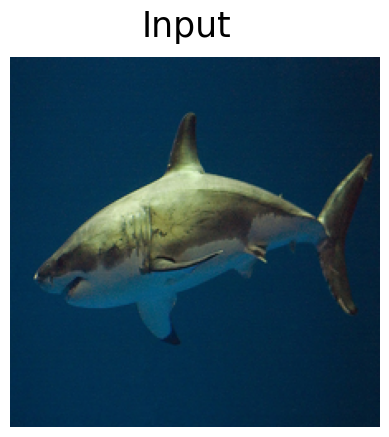

In [8]:
im = Image.open("images/shark.JPEG").resize((224,224))
plt.imshow(im)
plt.suptitle("Input", fontsize = 25)
plt.axis("off")

In [9]:
img = model.preprocessor(im).bfloat16().to(device).unsqueeze(0)

attns = {}
def hook_attn(module, input, output):
    attns[-1] = output

patches = {}
def hook_output_patch(module, input, output):
    patches[-1] = output


# Hook the last layer attention and output patches
hook_handle1 = model.model.visual.transformer.resblocks[-1].attn.attn_map.register_forward_hook(hook_attn)
hook_handle2 = model.model.visual.transformer.resblocks[-1].register_forward_hook(hook_output_patch)
_ = model.encode_image(img, neuron_dict=None, num_register_tokens=0)

hook_handle1.remove()
hook_handle2.remove()

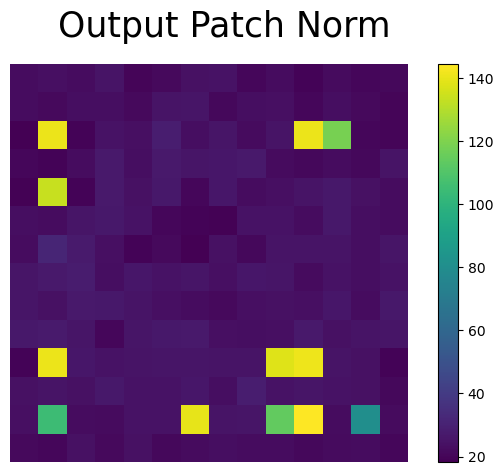

In [10]:
patch_norms = torch.norm(patches[-1].float().squeeze(0), dim=-1).detach().cpu().numpy()

plt.axis('off')
plt.suptitle("Output Patch Norm", fontsize=25)

im = plt.imshow(patch_norms[1:].reshape(patch_side, patch_side))
plt.colorbar(im)

plt.tight_layout()
plt.show()

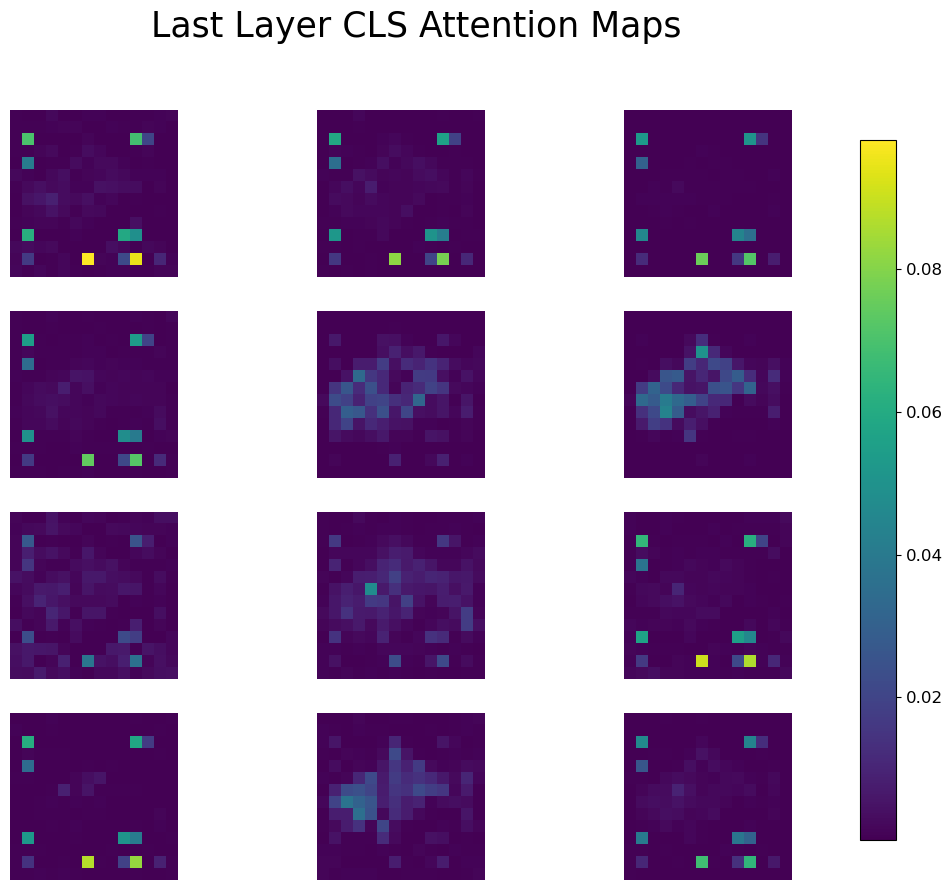

In [11]:
maps = attns[-1].float().squeeze(0).detach().cpu().numpy()
fig, axes = plt.subplots(4, num_heads // 4, figsize=(12, 10))
axes = axes.flatten()

# Find the global min and max for consistent color scaling
vmin = maps[:, 0, 1:].min()
vmax = maps[:, 0, 1:].max()

for i in range(num_heads):
    im = axes[i].imshow(maps[i][0, 1:].reshape(patch_side, patch_side), vmin=vmin, vmax=vmax)
    axes[i].axis('off')

plt.suptitle("Last Layer CLS Attention Maps", fontsize=25)


plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)

plt.show()

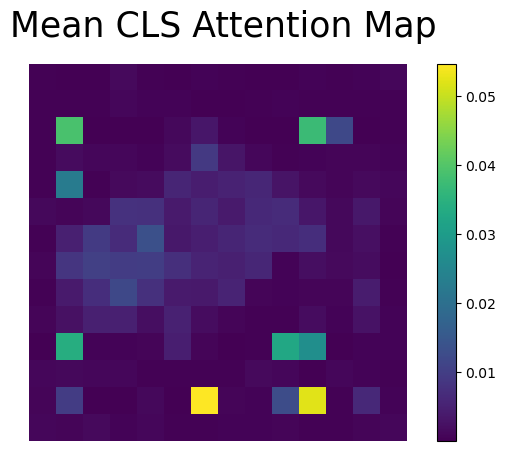

In [12]:
mean_map = attns[-1].float().squeeze(0).mean(0).detach().cpu().numpy()
im = plt.imshow(mean_map[0, 1:].reshape(patch_side, patch_side))
plt.suptitle("Mean CLS Attention Map", fontsize = 25)
plt.tight_layout()
plt.axis("off")
plt.colorbar(im)
plt.show()


# With Test-Time Register

In [13]:
with torch.no_grad():
    correct = [0, 0]
    for i, (images, target) in enumerate(tqdm(loader)):
        images = images.to(device).bfloat16()

        target = target.to(device).bfloat16()


        # predict
        image_features = model.encode_image(images)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = 100. * image_features @ classifier

        pred = logits.argmax(dim=-1)
        correct[0] += (pred == target).sum().item()
        correct[1] += target.size(0)



print(correct[0]/correct[1])


100%|██████████| 500/500 [00:55<00:00,  8.98it/s]

0.7129


(-0.5, 223.5, 223.5, -0.5)

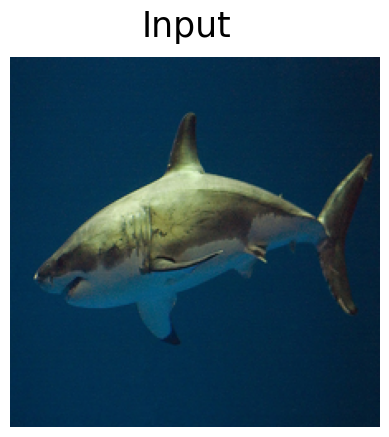

In [14]:
im = Image.open("images/shark.JPEG").resize((224,224))
plt.imshow(im)
plt.suptitle("Input", fontsize = 25)
plt.axis("off")

In [15]:
img = model.preprocessor(im).bfloat16().to(device).unsqueeze(0)

attns = {}
def hook_attn(module, input, output):
    attns[-1] = output

patches = {}
def hook_output_patch(module, input, output):
    patches[-1] = output


# Hook the last layer attention and output patches
hook_handle1 = model.model.visual.transformer.resblocks[-1].attn.attn_map.register_forward_hook(hook_attn)
hook_handle2 = model.model.visual.transformer.resblocks[-1].register_forward_hook(hook_output_patch)
_ = model.encode_image(img)

hook_handle1.remove()
hook_handle2.remove()

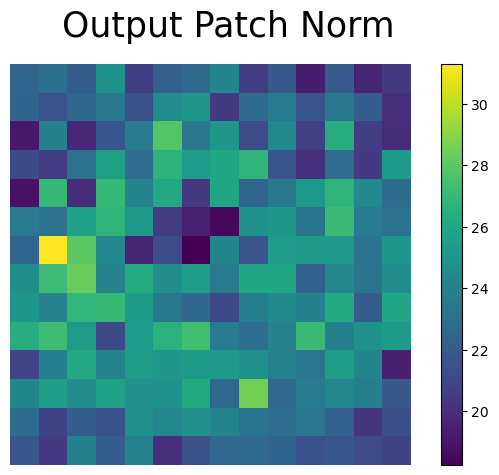

In [16]:
patch_norms = torch.norm(patches[-1].float().squeeze(0), dim=-1).detach().cpu().numpy()

plt.axis('off')
plt.suptitle("Output Patch Norm", fontsize=25)

im = plt.imshow(patch_norms[1:-1].reshape(patch_side, patch_side))
plt.colorbar(im)

plt.tight_layout()
plt.show()

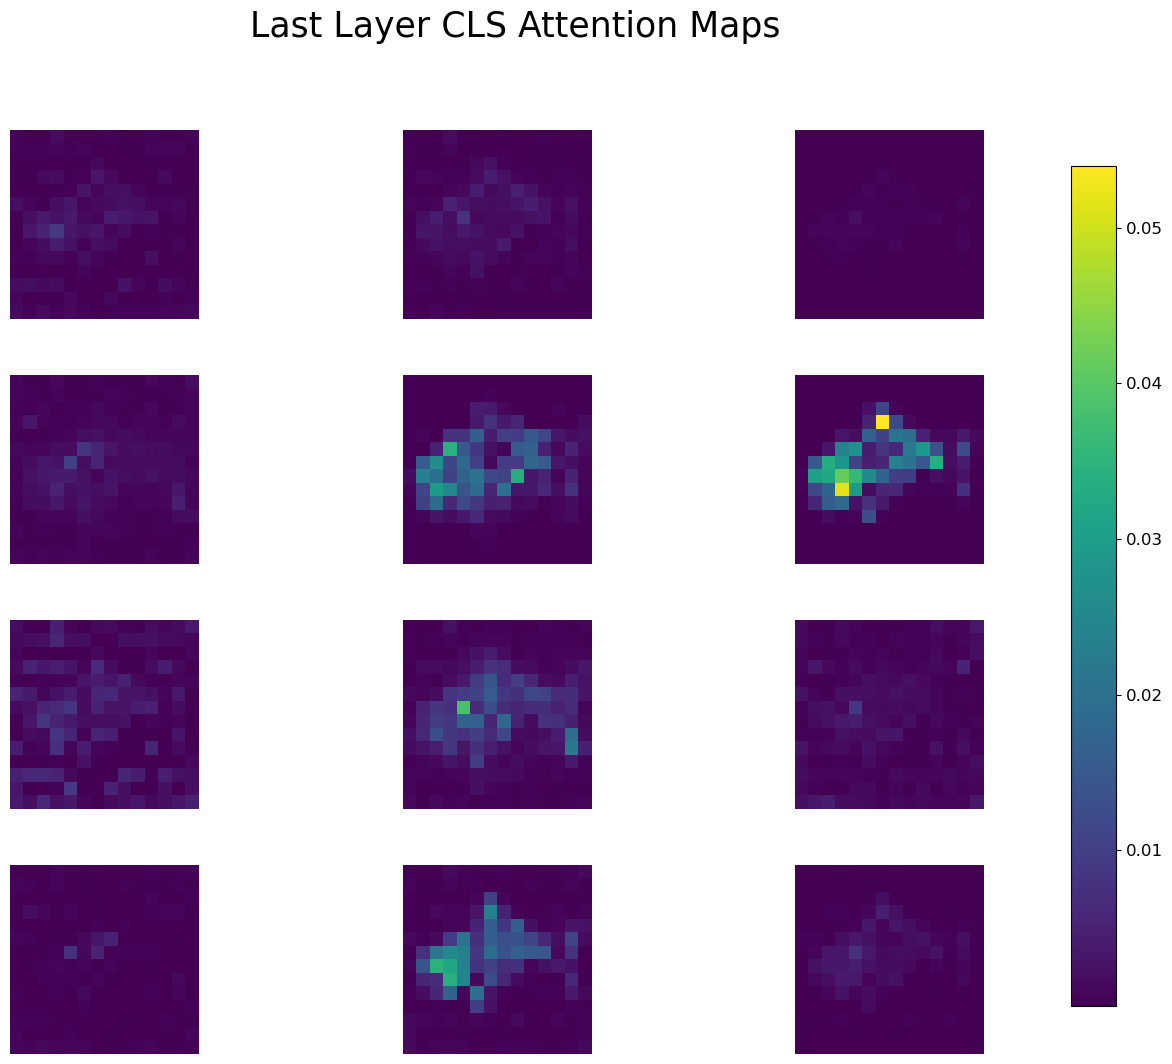

In [17]:
maps = attns[-1].float().squeeze(0).detach().cpu().numpy()
fig, axes = plt.subplots(4, num_heads // 4, figsize=(15, 12))  # Increased figure size
axes = axes.flatten()

# Find the global min and max for consistent color scaling
vmin = maps[:, 0, 1:-1].min()
vmax = maps[:, 0, 1:-1].max()

for i in range(num_heads):
    im = axes[i].imshow(maps[i][0, 1:-1].reshape(patch_side, patch_side), vmin=vmin, vmax=vmax)
    axes[i].axis('off')

plt.suptitle("Last Layer CLS Attention Maps", fontsize=25)

# Adjusted spacing for better layout
plt.subplots_adjust(right=0.85, hspace=0.3, wspace=0.3)  # Added spacing between subplots
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)

plt.show()

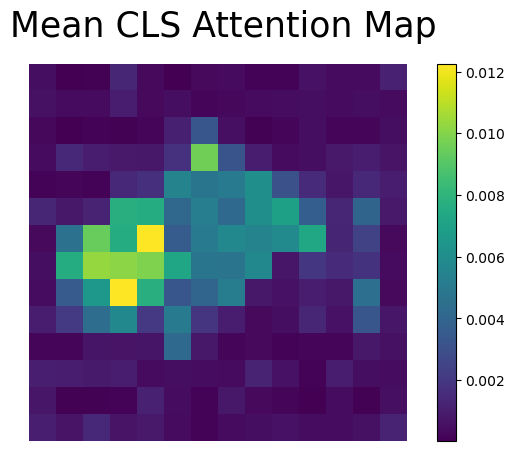

In [18]:
mean_map = attns[-1].float().squeeze(0).mean(0).detach().cpu().numpy()
im = plt.imshow(mean_map[0, 1:-1].reshape(patch_side, patch_side))
plt.suptitle("Mean CLS Attention Map", fontsize = 25)
plt.tight_layout()
plt.axis("off")
plt.colorbar(im)
plt.show()
